# import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import scipy
import pingouin as pg
import scipy
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_1samp
import numpy as np
from itertools import combinations
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns
from typing import List, Union
import math



# Define a type for nested lists of numbers
Nested = Union[float, List['Nested']]

def flatten(data: Nested) -> List[float]:
    """Recursively pull out all numeric values into a flat list."""
    if isinstance(data, list):
        vals = []
        for item in data:
            vals.extend(flatten(item))
        return vals
    else:
        return [data]

def plot_ETA(ax,average_signal,sems,random_average_signal,rand_sems):

    time_seconds = np.linspace(-1,1,5000)
    ax[0].plot(time_seconds,average_signal,color = 'red', label = 'replay aligned', alpha = 0.8)
    ax[1].plot(time_seconds,random_average_signal, color = 'blue', label = 'random non replay times', alpha = 0.8)
    ax[0].axvline(0,color= 'k', alpha = 0.2)
    ax[0].set_title('spindle band event triggered av.')

    upper = average_signal + sems
    lower = average_signal - sems
    ax[0].fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    upper = random_average_signal + rand_sems
    lower = random_average_signal - rand_sems
    ax[1].fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    ax[1].set_ylabel('spindle band power (zscore)')
    ax[1].set_xlabel('time (s)')
    
    ax[0].set_ylim(-0.05,0.04)
    ax[1].set_ylim(-0.05,0.04)
    
    return time_seconds

def compute_stats(flat_vals: List[float]) -> (float, float):
    """Return mean and standard deviation of a list of numbers."""
    n = len(flat_vals)
    mean = sum(flat_vals) / n
    var  = sum((x - mean)**2 for x in flat_vals) / n
    return mean, math.sqrt(var)

def zscoreize(data: Nested, mean: float, std: float) -> Nested:
    """
    Recursively replace each numeric entry by its z-score.
    Leaves the nesting structure intact.
    """
    if isinstance(data, list):
        return [zscoreize(item, mean, std) for item in data]
    else:
        return (data - mean) / std

def plot_decay(linked_binned_rate,linked_bins_relative_so,unlinked_binned_rate,unlinked_bins_relative_so,color_1, color_2, title_):
    fig,ax = plt.subplots(1, 1,figsize=(7, 5))
    AA_rate = []
    AA_post_so_time = []
    times = []
    rates = []
    for i,item in enumerate(unlinked_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(unlinked_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_1, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
        
    AA_rate = []
    AA_post_so_time = []
    times_2 = []
    rates_2 = []
    for i,item in enumerate(linked_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(linked_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_2, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times_2 += across_chunks_y[0:-1]
        rates_2 += list(rate_change_per_min)
        
    ax.set_title(title_)
    ax.set_xlabel('time after sleep onset (mins)')
    
    ax.set_ylabel('z score reactivation rate (per min)')

    fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
    sns.regplot(x=times, y=rates, ax = ax, color = color_1,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    sns.regplot(x=times_2, y=rates_2, ax = ax, color = color_2,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    ax.set_xlabel('starting rate')
    ax.set_ylabel('rate change per minute')
    ax.axhline(0,0,ls ='--')
    
    group1_data = {'x': times, 'y': rates}
    group2_data = {'x': times_2, 'y': rates_2}

    return group1_data, group2_data

def extract_start_end_points(start_end_df):
    all_chunk_forward_start_mean = []
    all_chunk_forward_end_mean = []
    all_chunk_reverse_start_mean = []
    all_chunk_reverse_end_mean = []

    # s_o_d = []
    for mouse,group in start_end_df.groupby('mouse'):
        chunk_forward_start_mean = []
        chunk_forward_end_mean = []
        chunk_reverse_start_mean = []
        chunk_reverse_end_mean = []
        for diff, chunk in group.groupby('chunk_number'):
            forward_chunk = chunk[chunk.label == 'forward']
            chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
            chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

            reverse_chunk = chunk[chunk.label == 'reverse']
            chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
            chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

        all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
        
    return all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str, color_):
        
    ## plot forward start and ends

    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = color_, width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)

    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)


        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')


    ax2.set_xlim(0,100)
    
def collapse(freqs, cap=6):
    # force presence of all bins
    out = {str(i): [] for i in range(1, cap + 1)}

    for k, v in freqs.items():
        kk = str(cap if int(k) >= cap else int(k))
        out[kk].extend(v)

    return out

def plot_group(ax, counts, keys, x_offset, color, stat_fn):
    for k in keys:
        y = counts[k]
        if len(y) == 0:
            continue

        if sum(y) == 0:
            continue
        x = float(k) + x_offset
        ax.plot(np.full(len(y), x), y, 'o',
                c=color, alpha=0.5, ms=9, mew=0)
        ax.plot(x, stat_fn(y), '<',
                c=color, alpha=0.8, ms=9, mew=0)


def permanova_coactive_freqs(dat1, dat2, cap=6):
    keys = [str(i) for i in range(1, cap + 1)]

    n1 = len(dat1['1'])
    n2 = len(dat2['1'])

    df = pd.DataFrame()
    df['groups'] = ['control'] * n1 + ['lesion'] * n2

    for k in keys:
        v1 = dat1.get(k, []).copy()
        v2 = dat2.get(k, []).copy()

        v1 += [0] * (n1 - len(v1))
        v2 += [0] * (n2 - len(v2))

        df[k] = v1 + v2

    values = df[keys].values
    grouping = df['groups'].values

    pairwise_distances = pdist(values, metric='euclidean')
    dm = DistanceMatrix(squareform(pairwise_distances))

    results = permanova(dm, grouping, permutations=10000)
    print(results)

    # --------------------------------------------------------
    # Effect size R² (distance-based)
    # --------------------------------------------------------
    D = dm.data
    n = len(grouping)
    ss_total = np.sum(D ** 2) / n

    ss_between = 0
    for g in np.unique(grouping):
        idx = np.where(grouping == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total

    print('***************************************************')
    print(f"PERMANOVA effect size R²: {r2:.5f}")





def plot_ordered_misrodered(nrem_ordered_misordered,var_string,var_string2):

    ordered = [item[0] for item in nrem_ordered_misordered]
    misordered = [item[1] for item in nrem_ordered_misordered]

    fig, ax = plt.subplots(figsize=(2, 5))

    ax.plot(np.zeros(len(ordered)), ordered, 'o', color = '#69BD45',alpha = 0.4)
    ax.boxplot([x for x in ordered if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
    ax.plot(np.ones(len(misordered)), misordered, 'o', color = '#32495C',alpha = 0.4)
    ax.boxplot([x for x in misordered if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

    ax.set_ylabel(var_string2)
    
    ax.set_title(var_string)
    
def cohens_d(x, y):
    """
    Compute Cohen's d for two independent samples.
    """
    x = np.array(x)
    y = np.array(y)
    nx = len(x)
    ny = len(y)
    # Pooled standard deviation
    pooled_std = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / (nx + ny - 2))
    d = (x.mean() - y.mean()) / pooled_std
    return d

def permutation_test(list1, list2):
    # Define your test statistic function
    def test_statistic(list1, list2):
        return np.mean(list1) - np.mean(list2)

    # Compute the observed test statistic
    observed_statistic = test_statistic(list1, list2)

    # Combine the two lists
    combined_data = list1 + list2

    # Number of permutations
    num_permutations = 100000

    # Initialize an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Permutation test
    for i in range(num_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined_data)
        
        # Split the shuffled data back into two lists
        permuted_list1 = combined_data[:len(list1)]
        permuted_list2 = combined_data[len(list1):]
        
        # Compute the test statistic for the permuted data
        permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

    # Calculate the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)


    plt.figure(figsize=(4, 3))
    plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
    plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of Permuted Test Statistics')
    plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
    plt.xlabel('Test Statistic')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    print("- p-value:", p_value)
    print('- 99th percentile of permuted statistics:',np.percentile(permuted_statistics, 99))
    print("- Observed Test Statistic:", observed_statistic)

def permanova_ordered_misordered(nrem, rem):

    df = pd.DataFrame(nrem + rem, columns=['ordered','misordered'])
    df['group'] = ['nrem']*len(nrem) + ['rem']*len(rem)

    # drop any NaNs
    df = df.dropna()

    # compute distance matrix
    dm = DistanceMatrix(
        squareform(pdist(df[['ordered','misordered']].values, 'euclidean'))
    )

    # run PERMANOVA
    res = permanova(dm, grouping=df['group'].tolist(), permutations=999)
    print(res)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(df['group'].tolist())
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(df['group'].tolist())
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")


def manova_groups_neuron_involvement(data1,data2):

    nrem_means = []
    for key in data1:
        if len(data1[key]) > 0:
            nrem_means += [np.nanmean(data1[key])]
    rem_means = []       
    for key in data2:
        if len(data2[key]) > 0:
            rem_means += [np.nanmean(data2[key])]

    x = nrem_means
    y = sorted(data1)

    x2 = rem_means
    y2 = sorted(data2)

    import statsmodels.api as sm
    from statsmodels.multivariate.manova import MANOVA

    A = pd.DataFrame({'x': x,
                    'y': y,
                    'groups': ['A'] * len(x)})
    B = pd.DataFrame({'x': x2,
                    'y': y2,
                    'groups': ['B'] * len(x2)})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)


    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    print(manova.mv_test())
    
    return manova.mv_test()
    

def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for index_, item, in enumerate(awake_dat):
        for index, awake_mouse_data in enumerate(item):

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[index_][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            for bin_ in bins:
                mask = np.round(awake,1) == bin_
                if len(sleep[mask]) > min_neurons_filter:
                    if bin_ in awake_sleep_relationship:
                        awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                    else:
                        awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship


def plot_awake_sleep_relationship(awake_sleep_relationship,color_,ax):

    keys = []
    e_means = []
    sem = []
    for key in awake_sleep_relationship:
        if len(awake_sleep_relationship[key]) > 0:
            keys += [key]
    #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')

            a_s_relationship = [x for x in awake_sleep_relationship[key] if not np.isnan(x)]

            e_means += [np.mean(a_s_relationship)]
            sem += [scipy.stats.tstd(a_s_relationship)]
    ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = color_, markersize = 10)

    upper = np.array(e_means)[np.argsort(keys)] + sem
    lower = np.array(e_means)[np.argsort(keys)] - sem
    ax.fill_between(sorted(keys),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    x = np.linspace(0, 1, 10)  # Example x values
    y = x  # Since x equals y, y values are the same as x values
    plt.plot(x,y,'--')


    ax.set_ylim(0,0.8)


    ax.set_ylabel('replay proportion involvement')
    ax.set_xlabel('awake proportion involvement')

    #################################################

    from scipy.optimize import curve_fit
    from scipy.stats import t

    # Extract the bins and corresponding values
    bins = list(awake_sleep_relationship.keys())
    
    bin_centers = np.array(bins)[np.argsort(bins)]
    values = np.array([np.nanmean(awake_sleep_relationship[bin]) for bin in bins])[np.argsort(bins)]

    # Define the exponential function
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model to the data
    popt, pcov = curve_fit(exponential_model, bin_centers, values)

    # Extract the fitting parameters
    a, b = popt

    # Calculate the fitted values
    fitted_values = exponential_model(bin_centers, *popt)

    # Calculate R-squared
    residuals = values - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - np.mean(values))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Degrees of freedom
    dof = max(0, len(bin_centers) - len(popt))

    # Calculate standard errors of the parameters
    perr = np.sqrt(np.diag(pcov))

    # Calculate t-values for the parameters
    t_values = popt / perr

    # Calculate p-values for the parameters
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    print(f'Fitted parameters: a = {a}, b = {b}')
    print(f'R-squared: {r_squared}')
    print(f'p-values: {p_values}')


# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict

def pairwise_permanova_by_feature(data, group_labels, method='bonferroni', permutations=10000):
    """
    Perform pairwise PERMANOVA on each feature column, correcting p-values
    across all feature×pairwise tests. For any pair where the feature is
    constant, record statistic=0, p_value=1 instead of running PERMANOVA.
    Returns a list of dicts:
      feature, group1, group2, test_stat, p_value, permutations
    """
    unique_groups = np.unique(group_labels)
    pairwise_combinations = list(combinations(unique_groups, 2))

    results = []
    all_pvals = []

    n_features = data.shape[1]

    for feat_idx in range(n_features):
        feat = data[:, feat_idx]

        for g1, g2 in pairwise_combinations:
            mask = np.isin(group_labels, [g1, g2])
            sub_feat = feat[mask]
            sub_labels = group_labels[mask]

            # If the feature is constant across these two groups, skip PERMANOVA:
            if np.unique(sub_feat).size == 1:
                stat, pval = 0.0, 1.0
                r2 = 0
            else:
                # Compute distances and run PERMANOVA
                dist_mat = squareform(pdist(sub_feat[:, None], metric='euclidean'))
                dist_mat = np.ascontiguousarray(dist_mat)
                ids = [str(i) for i in range(len(sub_labels))]
                dm = DistanceMatrix(dist_mat, ids)
                res = permanova(dm, sub_labels, permutations=permutations)
                stat, pval = res["test statistic"], res["p-value"]
                
                #Compute R² manually (effect size)
                # ss_total = sum of squared distances / n
                D = dm.data        # <-- this is the fix
                n = len(sub_labels)
                ss_total = np.sum(D**2) / n

                # ss_between: sum of squared group means
                group_labels = np.array(sub_labels)
                unique_groups = np.unique(group_labels)
                ss_between = 0
                for g in unique_groups:
                    idx = np.where(group_labels == g)[0]
                    Di = D[np.ix_(idx, idx)]
                    ss_between += len(idx) * (Di.mean() ** 2)

                r2 = ss_between / ss_total

            results.append({
                "feature": feat_idx,
                "group1": g1,
                "group2": g2,
                "test_stat": stat,
                "p_value": pval,
                "permutations": permutations,
                "R2": r2
            })
            all_pvals.append(pval)

    # Multiple testing correction
    corrected = multipletests(all_pvals, method=method)[1]
    for i, cp in enumerate(corrected):
        results[i]["p_value"] = cp
        
    return results


def permanova_forward_vs_reverse(f_warp_factors, r_warp_factors):
    grouping = ['control_forwards']*len(np.vstack(f_warp_factors)) + ['control_reverse']*len(np.vstack(r_warp_factors))

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors), metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        if sum(item) > 0:
            # normalize the warp factors to sum to 1
            rels += [list(np.array(item)/sum(item))]
    return rels


def extract_mean_warps(regression_df, bins_,animals_list):

    f_warp_factors = []
    r_warp_factors = []

    forward = []
    reverse = []
    
    forward_total = []
    reverse_total = []

    for mouse in animals_list:
        mask = regression_df.mouse == mouse
        group = regression_df[mask]
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        forward_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        f_warp_factors +=[list(example_totals.values())]
        forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        reverse_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        r_warp_factors +=[list(example_totals.values())]
        reverse += [sum(example_totals.values())]
    
    f_warp_factors = relative_warp_values(f_warp_factors)
    r_warp_factors = relative_warp_values(r_warp_factors)
    
    return f_warp_factors, r_warp_factors, forward_total, reverse_total

def plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    for item in conactinate_nth_items(f_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'-->', color = color_, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    for item in conactinate_nth_items(r_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'--<', color = color_, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)
    
def group_difference_permanova(f_warp_factors, r_warp_factors, learning_f_warp_factors, learning_r_warp_factors):

    # grouping = ['control_forwards']*len(np.vstack(e_f_warp_factors)) + ['control_reverse']*len(np.vstack(e_r_warp_factors)) + ['lesion_forwards']*len(np.vstack(hl_f_warp_factors)) + ['lesion_reverse']*len(np.vstack(hl_r_warp_factors))
    grouping = ['control']*len(np.vstack(f_warp_factors)) + ['control']*len(np.vstack(r_warp_factors)) + ['test']*len(np.vstack(learning_f_warp_factors)) + ['test']*len(np.vstack(learning_r_warp_factors))
    # data is stacked so that each row is a sample (animal) and each colum is a variable/test

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors+learning_f_warp_factors+learning_r_warp_factors), metric='euclidean')

    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")
    
    return grouping


def effect_size(x=None, y=None, test='ttest', dv=None, between=None, data=None,
                dm=None, grouping=None, popmean=None, permutations=999):
    """
    Calculate effect sizes for parametric, non-parametric, regression, and PERMANOVA.

    Parameters
    ----------
    x : array-like
        First sample (or single sample for one-sample t-test)
    y : array-like, optional
        Second sample (if applicable)
    test : str
        One of ['ttest', 'paired_ttest', 'one_sample_ttest', 'anova',
                'mannwhitney', 'wilcoxon', 'kruskal', 'correlation', 'permanova']
    dv, between, data : for ANOVA/Kruskal (pingouin syntax)
    dm : DistanceMatrix for PERMANOVA
    grouping : array-like of group labels for PERMANOVA
    popmean : population mean for one-sample t-test
    permutations : number of permutations for PERMANOVA
    """
    # Convert to numpy arrays if needed
    x = np.array(x) if x is not None else None
    y = np.array(y) if y is not None else None

    if test == 'ttest':  # independent
        t, p = stats.ttest_ind(x, y)
        pooled_std = np.sqrt(((len(x)-1)*x.std(ddof=1)**2 + (len(y)-1)*y.std(ddof=1)**2) / (len(x)+len(y)-2))
        d = (x.mean() - y.mean()) / pooled_std
        return {"cohens_d": d}

    elif test == 'paired_ttest':
        t, p = stats.ttest_rel(x, y)
        d = (x - y).mean() / (x - y).std(ddof=1)
        return {"cohens_d": d}

    elif test == 'one_sample_ttest':
        if popmean is None:
            raise ValueError("popmean must be provided for one-sample t-test")
        t, p = stats.ttest_1samp(x, popmean)
        d = (np.nanmean(x) - popmean) / x.std(ddof=1)
        return {"cohens_d": d}

    elif test == 'anova':
        res = pg.anova(dv=dv, between=between, data=data, detailed=True)
        return res[['Source', 'F', 'p-unc', 'eta-square', 'partial_eta-square']]

    elif test == 'mannwhitney':
        res = pg.mwu(x, y, alternative='two-sided', effsize='r')
        return {"test": "Mann-Whitney U", "U": res['U-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'wilcoxon':
        res = pg.wilcoxon(x, y, alternative='two-sided')
        return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'kruskal':
        res = pg.kruskal(data=data, dv=dv, between=between)
        return res[['H', 'p-unc', 'eta-square', 'eps-square']]

    elif test == 'correlation':
        r, p = stats.pearsonr(x, y)
        return {"test": "Pearson correlation", "r": r, "p": p}

    else:
        raise ValueError(f"Unsupported test type: {test}")
    

# figure A

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_52556\527773886.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


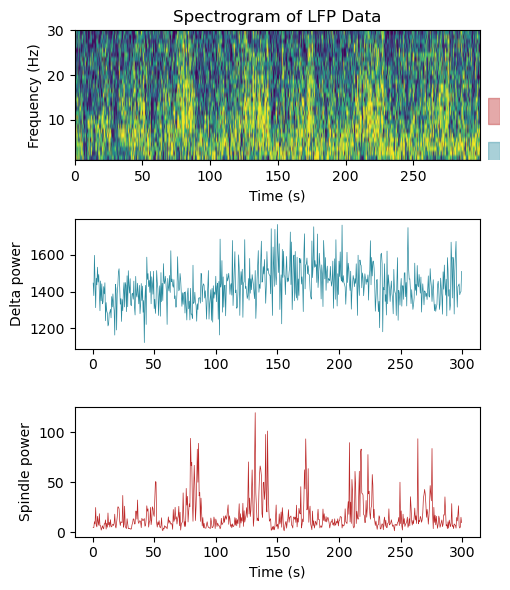

In [2]:
data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED8\lfp_spectrogram_figure_data.npz", allow_pickle=True)

log_power = data["log_power"]
frequencies = data["frequencies"]
times = data["times"]

delta_spectral_power = data["delta_spectral_power"]
delta_timestamps = data["delta_timestamps"]

spindle_spectral_power = data["spindle_spectral_power"]
spindle_timestamps = data["spindle_timestamps"]

vmin = float(data["vmin"])
vmax = float(data["vmax"])
fmin_plot = float(data["fmin_plot"])
fmax_plot = float(data["fmax_plot"])
cmap = str(data["cmap"])

# plot

fig, [ax, ax1, ax2] = plt.subplots(3, 1, figsize=(5, 6), sharex=False)

im = ax.imshow(
    log_power,
    aspect="auto",
    origin="lower",
    cmap=cmap,
    extent=[0, times.max(), frequencies.min(), frequencies.max()],
    vmin=vmin,
    vmax=vmax,
)

ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (s)")
ax.set_title("Spectrogram of LFP Data")
ax.set_ylim(fmin_plot, fmax_plot)

# Highlight frequency bands
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create a narrow axis to the right of the spectrogram
ax_band = inset_axes(
    ax,
    width="3%",      # thin vertical bar
    height="100%",
    loc="lower left",
    bbox_to_anchor=(1.02, 0, 1, 1),  # push it outside to the right
    bbox_transform=ax.transAxes,
    borderpad=0,
)
# Match frequency limits
ax_band.set_ylim(fmin_plot, fmax_plot)
ax_band.set_xlim(0, 1)
# Drw bands
ax_band.axhspan(0.5, 5, color="#298A9E", alpha=0.4)
ax_band.axhspan(9, 15, color="#BC2828", alpha=0.4)
# Clean up axis
ax_band.set_xticks([])
ax_band.set_yticks([])
ax_band.set_frame_on(False)

# Delta power
ax1.plot(delta_timestamps, delta_spectral_power, color = "#298A9E", linewidth = 0.5)
ax1.set_ylabel("Delta power")

# Spindle power
ax2.plot(spindle_timestamps, spindle_spectral_power, color = "#BC2828",linewidth = 0.5)
ax2.set_ylabel("Spindle power")
ax2.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


# figure B

In [3]:
import numpy as np

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED_8\spectral_power_replay_plot_data.npz", allow_pickle=True)

chunk_time= data['chunk_time']
# Delta
delta_spectral_powers = data["delta_spectral_powers"]
delta_spectral_timestamps = data["delta_spectral_timestamps"]
delta_replay_binned = data["delta_replay_binned"]
delta_replay_bin_ts = data["delta_replay_bin_ts"]

# Spindle
spndl_spectral_powers = data["spndl_spectral_powers"]
spndl_spectral_timestamps = data["spndl_spectral_timestamps"]
spndl_replay_binned = data["spndl_replay_binned"]
spndl_replay_bin_ts = data["spndl_replay_bin_ts"]

fig,ax= plt.subplots(1, 1,figsize=(4, 3))
# # Calculate bin centers
var_string = 'delta'
# Calculate log spectral power
log_power = np.log10(delta_spectral_powers)
# Optional: Smooth
smoothed_log_power = convolve_movmean(log_power, 30)
ax.plot(delta_spectral_timestamps,smoothed_log_power, 'blue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('delta',color = 'blue')
ax2 = ax.twinx()
ax2.plot(delta_replay_bin_ts,convolve_movmean(delta_replay_binned,30), color = 'k')
ax2.set_ylabel('replay rate', color = 'k')
ax.set_xlim(chunk_time[0], chunk_time[1])

fig,ax= plt.subplots(1, 1,figsize=(4, 3))
# # Calculate bin centers
var_string = 'spindle'
# Calculate log spectral power
log_power = np.log10(spndl_spectral_powers)
# Optional: Smooth
smoothed_log_power = convolve_movmean(log_power, 30)
ax.plot(spndl_spectral_timestamps,smoothed_log_power, 'red')
ax.set_xlabel('Time (s)')
ax.set_ylabel(var_string,color = 'red')
ax2 = ax.twinx()
ax2.plot(spndl_replay_bin_ts,convolve_movmean(spndl_replay_binned,30), color = 'k')
ax2.set_ylabel('replay rate', color = 'k')
ax.set_xlim(chunk_time[0], chunk_time[1])

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Emmett Thompson\\Documents\\procedural_replay_paper_2025\\data\\ED_8\\spectral_power_replay_plot_data.npz'

# figure C

In [7]:
import numpy as np

data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED8\delta_replay_xcorr_plot_data.npz", allow_pickle=True)

time_lags = data["time_lags"]

mean_delta_x_corr = data["mean_delta_x_corr"]
std_delta_x_corr = data["std_delta_x_corr"]

mean_delta_temporal_shuffle = data["mean_delta_temporal_shuffle"]
mean_delta_phase_shuffle = data["mean_delta_phase_shuffle"]

n = int(data["n"])


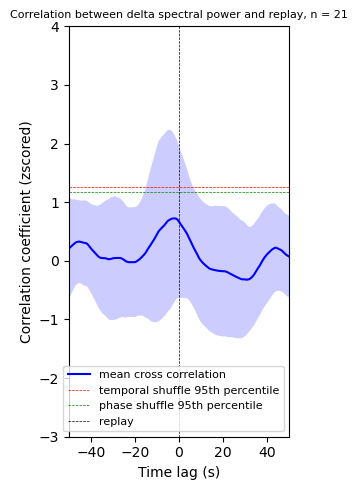

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(3, 5))

# Main cross-correlation
ax.plot(
    time_lags,
    mean_delta_x_corr,
    label="mean cross correlation",
    color="blue"
)

ax.fill_between(
    time_lags,
    mean_delta_x_corr - std_delta_x_corr,
    mean_delta_x_corr + std_delta_x_corr,
    alpha=0.2,
    color="blue",
    linewidth=0
)

# 95th percentiles from shuffle distributions
temporal_95 = np.percentile(mean_delta_temporal_shuffle, 95)
phase_95 = np.percentile(mean_delta_phase_shuffle, 95)

ax.axhline(
    temporal_95,
    color="red",
    lw=0.5,
    ls="--",
    label="temporal shuffle 95th percentile"
)

ax.axhline(
    phase_95,
    color="green",
    lw=0.5,
    ls="--",
    label="phase shuffle 95th percentile"
)

# Reference line at replay
ax.axvline(
    0,
    color="black",
    lw=0.5,
    ls="--",
    label="replay"
)

# Labels & formatting
ax.set_xlabel("Time lag (s)", size=10)
ax.set_ylabel("Correlation coefficient (zscored)", size=10)
ax.set_title(
    f"Correlation between delta spectral power and replay, n = {n}",
    fontsize=8
)

ax.set_xlim(-50, 50)
ax.set_ylim(-3, 4)
ax.legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np

data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED8\spindle_replay_xcorr_plot_data.npz", allow_pickle=True)

time_lags = data["time_lags"]

mean_spin_x_corr = data["mean_spin_x_corr"]
std_spin_x_corr = data["std_spin_x_corr"]

mean_spin_temporal_shuffle = data["mean_spin_temporal_shuffle"]
mean_spin_phase_shuffle = data["mean_spin_phase_shuffle"]

n = int(data["n"])


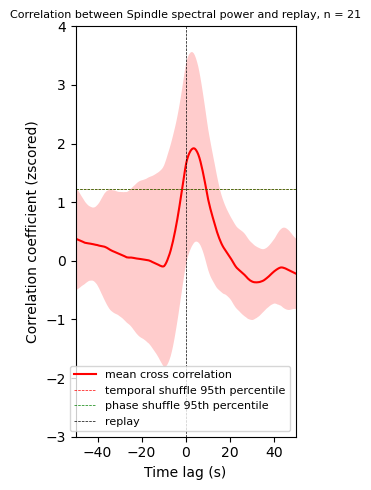

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(3, 5))

# Main cross-correlation
ax.plot(
    time_lags,
    mean_spin_x_corr,
    label="mean cross correlation",
    color="red"
)

ax.fill_between(
    time_lags,
    mean_spin_x_corr - std_spin_x_corr,
    mean_spin_x_corr + std_spin_x_corr,
    alpha=0.2,
    color="red",
    linewidth=0
)

# 95th percentile thresholds from shuffle distributions
temporal_95 = np.percentile(mean_spin_temporal_shuffle, 95)
phase_95 = np.percentile(mean_spin_phase_shuffle, 95)

ax.axhline(
    temporal_95,
    color="red",
    lw=0.5,
    ls="--",
    label="temporal shuffle 95th percentile"
)

ax.axhline(
    phase_95,
    color="green",
    lw=0.5,
    ls="--",
    label="phase shuffle 95th percentile"
)

# Replay reference
ax.axvline(
    0,
    color="black",
    lw=0.5,
    ls="--",
    label="replay"
)

# Labels & formatting
ax.set_xlabel("Time lag (s)", size=10)
ax.set_ylabel("Correlation coefficient (zscored)", size=10)
ax.set_title(
    f"Correlation between Spindle spectral power and replay, n = {n}",
    fontsize=8
)

ax.set_xlim(-50, 50)
ax.set_ylim(-3, 4)
ax.legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()


# figure D

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data
data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\ED_8\lfp_spindle_plot_data.npz", allow_pickle=True)

timeframe = data["timeframe"]
time_indices = data["time_indices"]

average_lfp = data["average_lfp"]
spindle_bandpassed = data["spindle_bandpassed"]
smoothed_envelope = data["smoothed_envelope"]

upper_threshold = data["upper_threshold"]
lower_threshold = data["lower_threshold"]

spindle_start_ends = data["spindle_start_ends"]
sampling_rate = int(data["sampling_rate"])


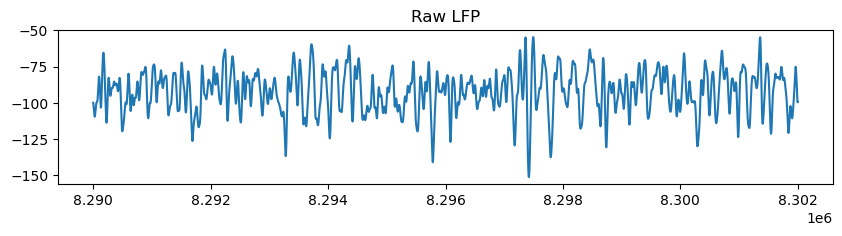

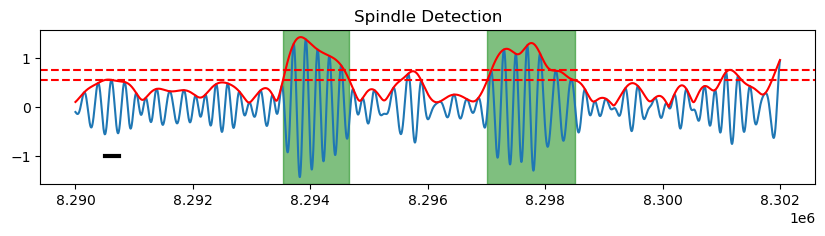

In [19]:
fig, ax = plt.subplots(figsize=(10, 2))

ax.plot(
    time_indices,
    average_lfp[timeframe[0]:timeframe[1]]
)

ax.set_title("Raw LFP")
plt.show()

fig, ax = plt.subplots(figsize=(10, 2))

ax.plot(
    time_indices,
    spindle_bandpassed[timeframe[0]:timeframe[1]],
    label="Bandpassed"
)

ax.plot(
    time_indices,
    smoothed_envelope[timeframe[0]:timeframe[1]],
    color="r",
    label="Envelope"
)

ax.axhline(upper_threshold, color="red", linestyle="--", label="Upper Threshold")
ax.axhline(lower_threshold, color="red", linestyle="--", label="Lower Threshold")

# Highlight spindle events
for start_sec, end_sec in spindle_start_ends:
    start = start_sec * sampling_rate
    end = end_sec * sampling_rate
    if start > timeframe[0] and end < timeframe[1]:
        ax.axvspan(start, end, alpha=0.5, color="green")

ax.set_title("Spindle Detection")

# Time scale bar
line_duration = int(sampling_rate / 10)  # 100 ms
start_x = timeframe[0] + 500
end_x = start_x + line_duration
y_value = -1

ax.plot([start_x, end_x], [y_value, y_value], color="k", linewidth=3)

plt.show()



# figure E

(0.0, 5.0)

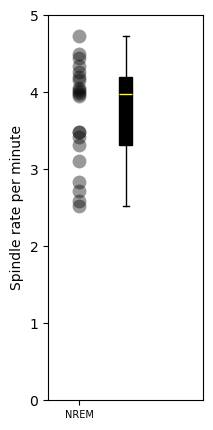

In [34]:
nrem_epm = np.array([2.83333333, 2.58823529, 2.52112676, 2.72268908, 3.10447761,
       4.02631579, 3.95070423, 4.25906736, 4.06153846, 4.33823529,
       4.16470588, 4.5       , 3.48611111, 3.42408377, 3.48447205,
       3.97826087, 4.2       , 4.72566372, 3.32085561, 4.0078125 ,
       4.44787645])

fig,ax,= plt.subplots(1, 1,figsize=(2, 5))
ax.plot(np.zeros(len(nrem_epm)),nrem_epm,'o', alpha = 0.4, markersize = 10, markeredgewidth = 0, color = 'k')
# add a box plot
ax.boxplot(nrem_epm, positions=[0.3], widths=0.08, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='yellow'))
# # remove the x ticks
ax.set_xticks([0])
# add x tick labels 
ax.set_xticklabels(['NREM'], fontsize = 7)
ax.set_ylabel('Spindle rate per minute')
ax.set_ylim(0,5)

# figure F

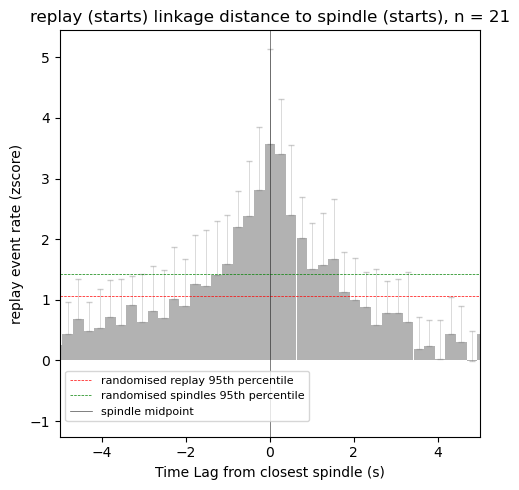

In [39]:

data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED8\spindle_linkage_distance_plot_data.npz", allow_pickle=True)

bins = data["bins"]
bin_centres = data["bin_centres"]

mean_spindle_linkage_distance = data["mean_spindle_linkage_distance"]
std_spindle_linkage_distance = data["std_spindle_linkage_distance"]

mean_spindle_linkage_distance_random_replay = data["mean_spindle_linkage_distance_random_replay"]
mean_spindle_linkage_distance_random_spindles = data["mean_spindle_linkage_distance_random_spindles"]

n = int(data["n"])

#######

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Bin widths
widths = np.diff(bins)

# Error bar styling
error_style = dict(
    ecolor="grey",
    elinewidth=0.5,
    capsize=2,
    alpha=0.4
)

# Bar plot
ax.bar(
    bin_centres,
    mean_spindle_linkage_distance,
    width=widths,
    yerr=[
        np.zeros_like(std_spindle_linkage_distance),
        std_spindle_linkage_distance
    ],
    align="center",
    alpha=0.6,
    color="grey",
    error_kw=error_style
)

# 95th percentile thresholds
replay_95 = np.percentile(
    mean_spindle_linkage_distance_random_replay, 95
)
spindle_95 = np.percentile(
    mean_spindle_linkage_distance_random_spindles, 95
)

ax.axhline(
    replay_95,
    color="red",
    lw=0.5,
    ls="--",
    label="randomised replay 95th percentile"
)

ax.axhline(
    spindle_95,
    color="green",
    lw=0.5,
    ls="--",
    label="randomised spindles 95th percentile"
)

# Formatting
ax.set_xlabel("Time Lag from closest spindle (s)")
ax.set_ylabel("replay event rate (zscore)")
ax.set_title(
    f"replay (starts) linkage distance to spindle (starts), n = {n}"
)

ax.axvline(
    0,
    color="k",
    alpha=0.7,
    label="spindle midpoint",
    linewidth=0.5
)

ax.set_xlim(-5, 5)
ax.legend(
    loc="center left",
    bbox_to_anchor=(0, 0.1),
    fontsize=8
)

plt.tight_layout()
plt.show()



# figure G

array([-1.        , -0.99959992, -0.99919984, ...,  0.99919984,
        0.99959992,  1.        ], shape=(5000,))

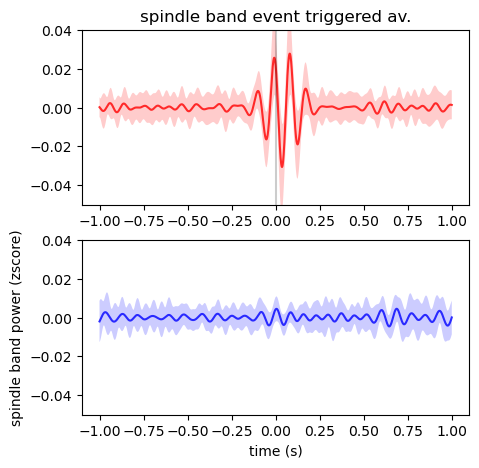

In [ ]:
data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED8\event_triggered_average_plot_data.npz", allow_pickle=True)

mean_signal_across_all = data["mean_signal_across_all"]
std_across_all = data["std_across_all"]

random_mean_signal_across_all = data["random_mean_signal_across_all"]
random_std_across_all = data["random_std_across_all"]

fig,ax= plt.subplots(2, 1,figsize=(5, 5))

plot_ETA(ax,mean_signal_across_all,std_across_all,random_mean_signal_across_all,random_std_across_all)


# figure J

Text(0, 0.5, 'Replay linked to spindles')

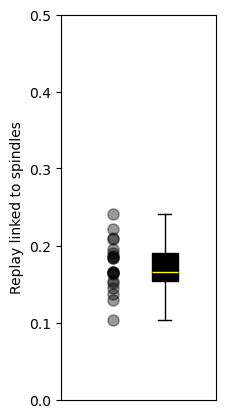

In [63]:
spin_linked_replay = [np.float64(0.1841620626151013),
 np.float64(0.16552667578659372),
 np.float64(0.18544600938967137),
 np.float64(0.16543665436654367),
 np.float64(0.13660477453580902),
 np.float64(0.1640560593569662),
 np.float64(0.186219739292365),
 np.float64(0.15142857142857144),
 np.float64(0.18433734939759036),
 np.float64(0.12965260545905707),
 np.float64(0.16540642722117202),
 np.float64(0.24083769633507854),
 np.float64(0.14526098901098902),
 np.float64(0.209375),
 np.float64(0.162656107219007),
 np.float64(0.20902394106813996),
 np.float64(0.15384615384615385),
 np.float64(0.19085173501577288),
 np.float64(0.10367892976588629),
 np.float64(0.22122762148337596),
 np.float64(0.19558359621451105)]


fig,ax,= plt.subplots(1, 1,figsize=(2, 5))


ax.plot(np.zeros(len(spin_linked_replay)),spin_linked_replay,'o', alpha = 0.4, markersize = 8, color = 'k')
# add a box plot
ax.boxplot(spin_linked_replay, positions=[0.2], widths=0.1, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='yellow'))
ax.set_ylim(0,0.5)
ax.set_xlim(-0.2,0.4)
# remove the x ticks
ax.set_xticks([])
ax.set_ylabel('Replay linked to spindles')

# figure K 

(0.0, 1.0)

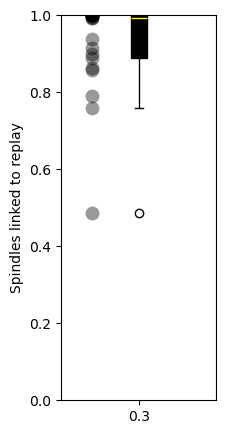

In [60]:
linked_proportion = [0.9387755102040817,
 0.7911392405063291,
 1.0,
 1.0,
 1.0,
 0.9949748743718593,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8877551020408163,
 1.0,
 0.7586206896551724,
 0.9936708860759493,
 0.9939393939393939,
 0.487012987012987,
 0.9145299145299145,
 0.8636363636363636,
 0.8982300884955752,
 0.8571428571428571]

    
fig,ax,= plt.subplots(1, 1,figsize=(2, 5))
ax.plot(np.zeros(len(linked_proportion)),linked_proportion,'o', alpha = 0.4, markersize = 10, markeredgewidth = 0, color = 'k')
# # add a box plot
ax.boxplot(linked_proportion, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='yellow'))
# # # remove the x ticks
ax.set_ylabel('Spindles linked to replay')
ax.set_ylim(0,1)

# figure L

In [3]:

#Load the pickled files

in_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\plotting_data\\"

# dump to pickle
with open(in_path + "LINKED_UNLIKNED_processed_replay_data.pkl", 'rb') as f:
    linked_unlinked_master = pickle.load(f)
    
with open(in_path + "awake_seqbyseq_neuron_involvements.pkl", 'rb') as f:
    neuron_involvement_master = pickle.load(f)
    

ShapiroResult(statistic=np.float64(0.8663454146686502), pvalue=np.float64(0.010140408277513233))
ShapiroResult(statistic=np.float64(0.9174009687943279), pvalue=np.float64(0.07700374181383939))
WilcoxonResult(statistic=np.float64(45.0), pvalue=np.float64(0.023950576782226562))
{'test': 'Wilcoxon signed-rank', 'W': np.float64(45.0), 'p': np.float64(0.023950576782226562), 'rank_biserial_r': np.float64(-0.5714285714285714)}


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_36924\3739040699.py:3: RuntimeWarning: Mean of empty slice
  linked_event_lens = [np.nanmean(item) for item in linked_event_lens]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_36924\3590721845.py:829: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


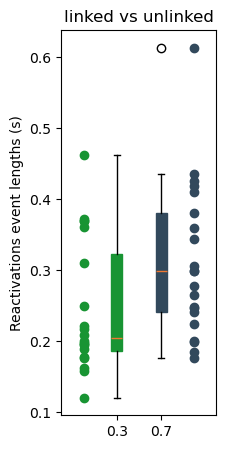

In [4]:
linked_event_lens = linked_unlinked_master['linked']['event_lens']
unlinked_event_lens = linked_unlinked_master['unlinked']['event_lens']
linked_event_lens = [np.nanmean(item) for item in linked_event_lens]
unlinked_event_lens = [np.nanmean(item) for item in unlinked_event_lens]

### PLOT
fig, ax = plt.subplots(figsize=(2, 5))
ax.plot(np.zeros(len(linked_event_lens)), linked_event_lens, 'o', color = '#189433')
ax.boxplot([x for x in linked_event_lens if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor="#189433", color='#189433'), medianprops=dict(color='#EE7832'))
ax.plot(np.ones(len(unlinked_event_lens)), unlinked_event_lens, 'o', color = '#32495C')
ax.boxplot([x for x in unlinked_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))
ax.set_ylabel('Reactivations event lengths (s)')
ax.set_title('linked vs unlinked')
### STATS
a = [x for x in linked_event_lens if not np.isnan(x)]
b = [x for x in unlinked_event_lens if not np.isnan(x)]
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.wilcoxon(linked_event_lens, unlinked_event_lens,nan_policy='omit'))
print(effect_size(x=linked_event_lens, y=unlinked_event_lens, test='wilcoxon'))

# figure M

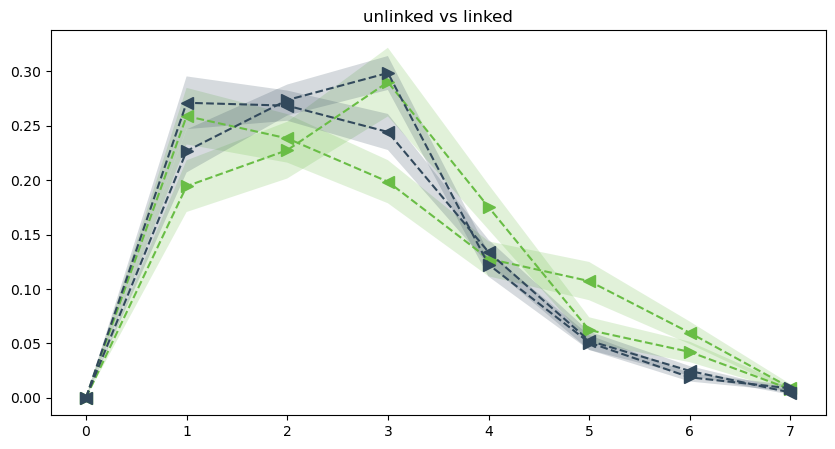

ShapiroResult(statistic=np.float64(0.8576212731786002), pvalue=np.float64(1.744496463167943e-11))
ShapiroResult(statistic=np.float64(0.8924007850346327), pvalue=np.float64(1.0779793335912844e-09))
ShapiroResult(statistic=np.float64(0.8677207709454446), pvalue=np.float64(5.357105250836415e-11))
ShapiroResult(statistic=np.float64(0.8754718610456639), pvalue=np.float64(1.317897591120251e-10))
----------------------------
permanova - forward reverse
----------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic             3.345871
p-value                    0.011599
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.74478
-------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic             2.213

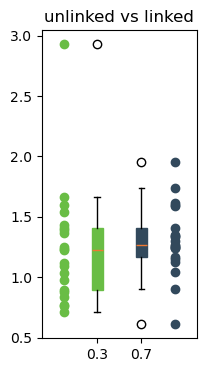

Inset: Difference from expected ------------------------
Test statistic: 2.3095942194862547
P-value: 0.031710042340827735
{'cohens_d': np.float64(0.503994777877534)}
--------------------
Test statistic: 4.866774290055714
P-value: 9.341924923733473e-05
{'cohens_d': np.float64(1.0620172178307277)}
----------------------
Inset: comparison forward/reverse ------------------------
ShapiroResult(statistic=np.float64(0.8035892796189777), pvalue=np.float64(0.0007447922912890895))
ShapiroResult(statistic=np.float64(0.960275394449744), pvalue=np.float64(0.5216901344904668))
WilcoxonResult(statistic=np.float64(75.0), pvalue=np.float64(0.16780662536621094))
{'test': 'Wilcoxon signed-rank', 'W': np.float64(75.0), 'p': np.float64(0.16780662536621094), 'rank_biserial_r': np.float64(-0.35064935064935066)}


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_36924\3590721845.py:829: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


In [5]:
bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]
animals_list = linked_unlinked_master['linked']['animals']

linked_f_warp_factors, linked_r_warp_factors, linked_forward_total, linked_reverse_total = extract_mean_warps(pd.DataFrame(linked_unlinked_master['linked']['regression']), bins_,animals_list)
linked_proportion_forward_v_reverse = np.array(linked_forward_total)/np.array(linked_reverse_total)
unlinked_f_warp_factors, unlinked_r_warp_factors, unlinked_forward_total, unlinked_reverse_total = extract_mean_warps(pd.DataFrame(linked_unlinked_master['unlinked']['regression']), bins_,animals_list)
unlinked_proportion_forward_v_reverse = np.array(unlinked_forward_total)/np.array(unlinked_reverse_total)

############################################################### PLOT 

fig,ax = plt.subplots(1, 1,figsize=(10, 5))
color_ = '#69BD45'
plot_warp_factors(ax, linked_f_warp_factors, linked_r_warp_factors, bins_, color_)
color_ = '#32495C'
plot_warp_factors(ax, unlinked_f_warp_factors, unlinked_r_warp_factors, bins_, color_)
ax.set_title('unlinked vs linked')
plt.show()

## STATS

print(scipy.stats.shapiro([item for sublist in linked_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in linked_r_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in unlinked_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in unlinked_r_warp_factors for item in sublist]))
print('----------------------------')
print('permanova - forward reverse')
print('----------------------------')
permanova_forward_vs_reverse(linked_f_warp_factors, linked_r_warp_factors)
print('-------------------')
permanova_forward_vs_reverse(unlinked_f_warp_factors, unlinked_r_warp_factors)
print('----------------------------')
print('permanova - group differences')
print('----------------------------')
# PERMANOVA late vs early diff
el_grouping = group_difference_permanova(linked_f_warp_factors, linked_f_warp_factors, unlinked_f_warp_factors, unlinked_f_warp_factors)
print('----------------------------')
print('posthoc - group differences')
print('----------------------------')
# Combine:
combined_data = np.vstack([
    np.asarray(linked_f_warp_factors),
    np.asarray(linked_r_warp_factors),
    np.asarray(unlinked_f_warp_factors),
    np.asarray(unlinked_r_warp_factors)
])
combined_labels = np.array(el_grouping)
feature_results = pairwise_permanova_by_feature(
    combined_data,
    combined_labels,
    method='bonferroni',
    permutations=10000
)
print("Significant feature-wise pairwise PERMANOVA results (α=0.05):")
for res in feature_results:
    p = res["p_value"]
    if p < 0.05:
        stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
        print(f"Feature {res['feature']}: {res['group1']} vs {res['group2']}")
        print(f"  statistic = {res['test_stat']:.4f}, p (corr.) = {p:.4g} {stars}")
        print(f"R2 = {res['R2']}")
        print("---")


#### PLOT inset
fig, ax = plt.subplots(figsize=(2, 4))
ax.plot(np.zeros(len(linked_proportion_forward_v_reverse)),linked_proportion_forward_v_reverse,'o', color = '#69BD45')
ax.boxplot([x for x in linked_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
ax.plot(np.ones(len(unlinked_proportion_forward_v_reverse)),unlinked_proportion_forward_v_reverse,'o', color = '#32495C')
ax.boxplot([x for x in unlinked_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))
ax.set_title('unlinked vs linked')
plt.show()

### STATS for inset
print('Inset: Difference from expected ------------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(linked_proportion_forward_v_reverse, 1.0)
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
print(effect_size(x=linked_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1))

print('--------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(unlinked_proportion_forward_v_reverse, 1.0, nan_policy="omit")
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
unlinked_proportion_forward_v_reverse_nanr = unlinked_proportion_forward_v_reverse[~np.isnan(unlinked_proportion_forward_v_reverse)]
print(effect_size(x=unlinked_proportion_forward_v_reverse_nanr,test='one_sample_ttest',popmean = 1))

print('----------------------')
print('Inset: comparison forward/reverse ------------------------')
print(scipy.stats.shapiro(linked_proportion_forward_v_reverse))
print(scipy.stats.shapiro(unlinked_proportion_forward_v_reverse))
# not all normal so use wilcoxn signed rank
print(scipy.stats.wilcoxon(linked_proportion_forward_v_reverse, unlinked_proportion_forward_v_reverse,nan_policy='omit'))
print(effect_size(x=linked_proportion_forward_v_reverse, y=unlinked_proportion_forward_v_reverse, test='wilcoxon'))

# figure N

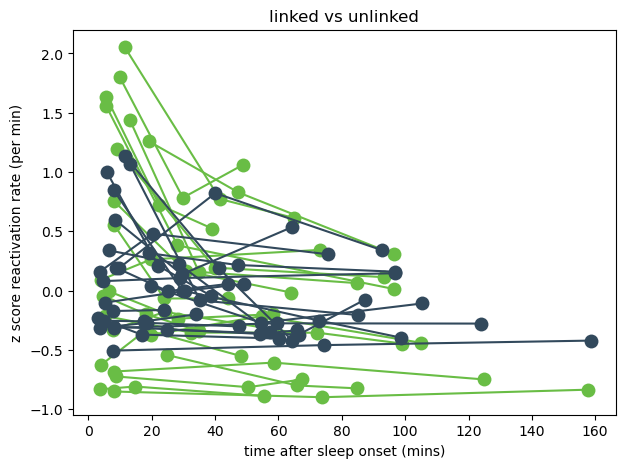

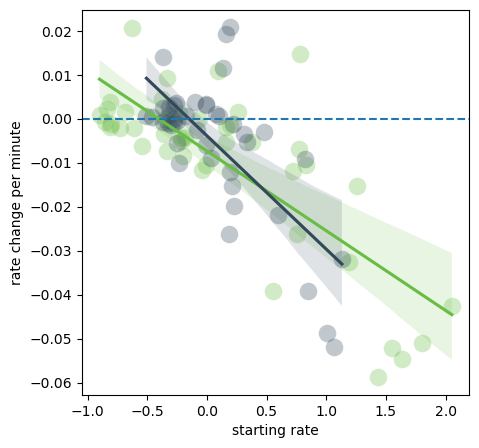

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.8203 2.0000 82.0000  8.9793 0.0003
         Pillai's trace 0.1797 2.0000 82.0000  8.9793 0.0003
 Hotelling-Lawley trace 0.2190 2.0000 82.0000  8.9793 0.0003
    Roy's greatest root 0.2190 2.0000 82.0000  8.9793 0.0003
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9823 2.0000 82.0000  0.7394 0.4806
         Pillai's trace 0.0177 2.0000 82.0000  0.7394 0.4806
 Hotelling-Lawley trace 0.0180 2.0000 82.0

In [6]:
# 1. Flatten
flat = flatten(linked_unlinked_master['linked']['binned_rate'])
# 2. Compute mean & std
mean = np.nanmean(flat)
std = np.nanstd(flat)
# 3. Recurse to z-score
normalized_linked = zscoreize(linked_unlinked_master['linked']['binned_rate'], mean, std)

# 1. Flatten
flat = flatten(linked_unlinked_master['unlinked']['binned_rate'])
# 2. Compute mean & std
mean = np.nanmean(flat)
std = np.nanstd(flat)
# 3. Recurse to z-score
normalized_unlinked = zscoreize(linked_unlinked_master['unlinked']['binned_rate'], mean, std)


group1_data, group2_data = plot_decay(normalized_linked  ,linked_unlinked_master['linked']['bins_relative_so'],normalized_unlinked ,linked_unlinked_master['unlinked']['bins_relative_so'], '#69BD45','#32495C','linked vs unlinked')
plt.show()

###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)

# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)

# Create a grouping variable
groups = np.array(['linked'] * len(df1) + ['unlinked'] * len(df2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)

### STATS for inset
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (linked):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (unlinked):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)

# figure O

c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


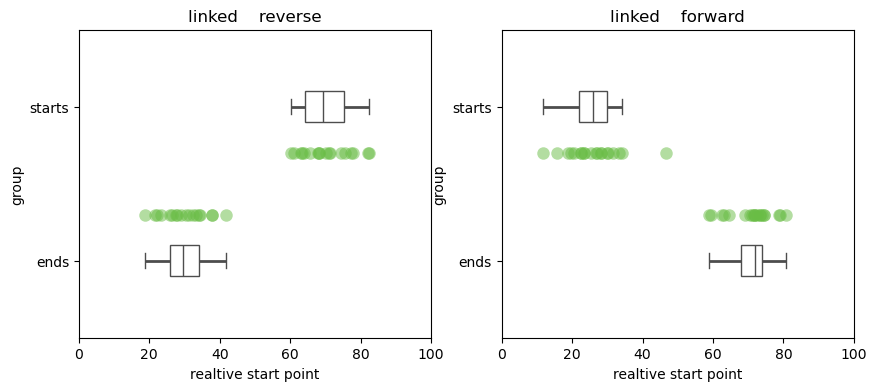

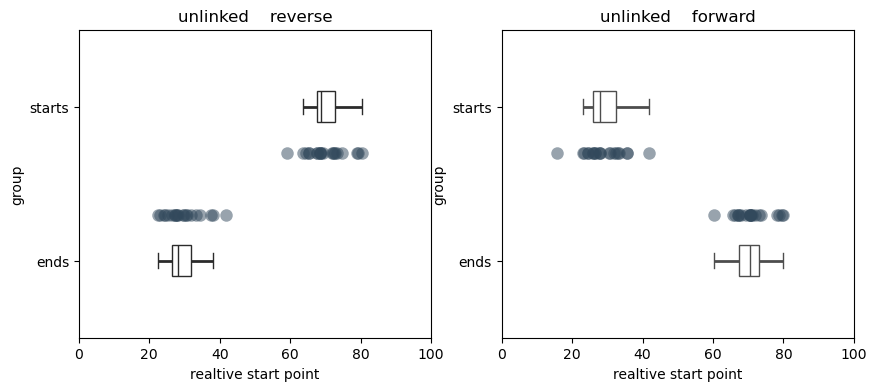

ShapiroResult(statistic=np.float64(0.9515132885266412), pvalue=np.float64(0.44924853226694567))
ShapiroResult(statistic=np.float64(0.9594748787520659), pvalue=np.float64(0.5334123915271906))
ShapiroResult(statistic=np.float64(0.9856815857475467), pvalue=np.float64(0.9896629615510701))
ShapiroResult(statistic=np.float64(0.9294240981794044), pvalue=np.float64(0.15052482819749347))
ShapiroResult(statistic=np.float64(0.9676918432915715), pvalue=np.float64(0.681599136764739))
ShapiroResult(statistic=np.float64(0.9699470601890785), pvalue=np.float64(0.7318643818822168))
ShapiroResult(statistic=np.float64(0.9409234849132666), pvalue=np.float64(0.22725189330651396))
ShapiroResult(statistic=np.float64(0.9354670857781555), pvalue=np.float64(0.17708648014706208))
_____________________________________________________________________________________________
                   Multivariate linear model
                                                               
----------------------------------

c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['linked']['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'linked','#69BD45')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['unlinked']['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'unlinked','#32495C')

plt.show()
#### STATS

linked_all_chunk_reverse_start_mean, linked_all_chunk_forward_start_mean, linked_all_chunk_reverse_end_mean, linked_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['linked']['start_end']))
unlinked_all_chunk_reverse_start_mean, unlinked_all_chunk_forward_start_mean, unlinked_all_chunk_reverse_end_mean, unlinked_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['unlinked']['start_end']))

group1= [x for x in linked_all_chunk_reverse_start_mean if not np.isnan(x)] 
group2 = [x for x in linked_all_chunk_forward_start_mean if not np.isnan(x)] 
group3 = [x for x in linked_all_chunk_reverse_end_mean if not np.isnan(x)] 
group4 = [x for x in linked_all_chunk_forward_end_mean if not np.isnan(x)] 
group5 = [x for x in unlinked_all_chunk_reverse_start_mean if not np.isnan(x)] 
group6 = [x for x in unlinked_all_chunk_forward_start_mean if not np.isnan(x)] 
group7 = [x for x in unlinked_all_chunk_reverse_end_mean if not np.isnan(x)] 
group8 = [x for x in unlinked_all_chunk_forward_end_mean if not np.isnan(x)] 

for group in [group1, group2, group3, group4, group5, group6, group7, group8]:
    print(scipy.stats.shapiro(group))
    
df_linked = pd.DataFrame({
    'group':       ['linked'] * len(linked_all_chunk_forward_start_mean),
    'forward_start': linked_all_chunk_forward_start_mean,
    'forward_end':   linked_all_chunk_forward_end_mean,
    'reverse_start': linked_all_chunk_reverse_start_mean,
    'reverse_end':   linked_all_chunk_reverse_end_mean,
})

df_unlinked = pd.DataFrame({
    'group':       ['unlinked'] * len(unlinked_all_chunk_forward_start_mean),
    'forward_start': unlinked_all_chunk_forward_start_mean,
    'forward_end':   unlinked_all_chunk_forward_end_mean,
    'reverse_start': unlinked_all_chunk_reverse_start_mean,
    'reverse_end':   unlinked_all_chunk_reverse_end_mean,
})


print('_____________________________________________________________________________________________')
from statsmodels.multivariate.manova import MANOVA
# Concatenate them:
df = pd.concat([df_linked, df_unlinked], ignore_index=True)
#  MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)



# figure P

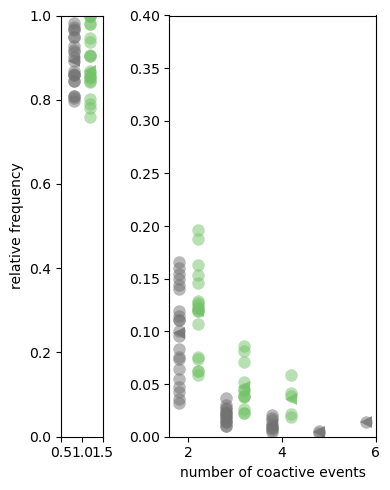

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic              0.23662
p-value                     0.70493
number of permutations        10000
Name: PERMANOVA results, dtype: object
***************************************************
PERMANOVA effect size R²: 0.70633


In [8]:
linked_counts = collapse(linked_unlinked_master['linked']['coactive_freqs'])
unlinked_counts = collapse(linked_unlinked_master['unlinked']['coactive_freqs'])

colors = {"unlinked": "#727272", "linked": "#74C269"}
offset = 0.2


# PLOT
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(4, 5),
    gridspec_kw={'width_ratios': [2, 10]}
)

# Left panel: coactive = 1 (median)
for counts, color, off in [
    (linked_counts, colors["linked"], offset),
    (unlinked_counts, colors["unlinked"], -offset)
]:
    plot_group(ax1, counts, ['1'], off, color, np.median)

ax1.set_xlim(0.5, 1.5)
ax1.set_ylim(0, 1)
ax1.set_ylabel('relative frequency')


# Right panel: coactive >= 2 (mean)
keys = [str(i) for i in range(2, 7)]

for counts, color, off in [
    (linked_counts, colors["linked"], offset),
    (unlinked_counts, colors["unlinked"], -offset)
]:
    plot_group(ax2, counts, keys, off, color, np.mean)

ax2.set_xlabel('number of coactive events')
ax2.set_ylim(0, 0.4)

plt.tight_layout()
plt.show()


# ============================================================
# STATS
# ============================================================
permanova_coactive_freqs(linked_counts, unlinked_counts)

# figure Q

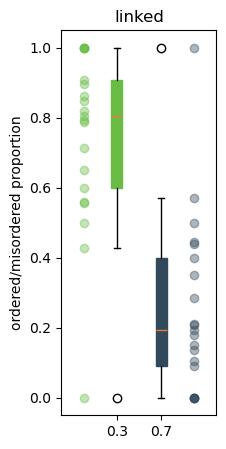

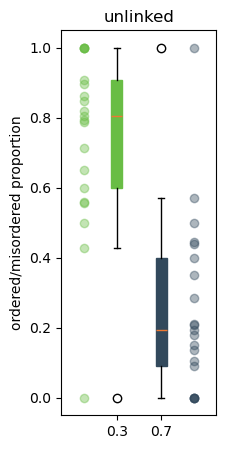

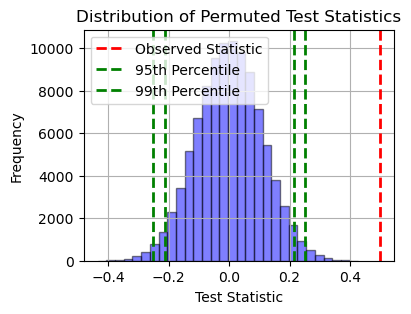

- p-value: 0.0
- 99th percentile of permuted statistics: 0.2528633013221512
- Observed Test Statistic: 0.49841261960299477
cohens d = 2.010567586993943
------------------


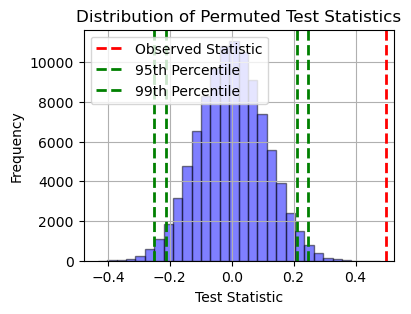

- p-value: 0.0
- 99th percentile of permuted statistics: 0.24797519061216608
- Observed Test Statistic: 0.49841261960299477
cohens d = 2.010567586993943
------------------
ShapiroResult(statistic=np.float64(0.8659900520951987), pvalue=np.float64(0.008112056845778818))
ShapiroResult(statistic=np.float64(0.8659900520951984), pvalue=np.float64(0.0081120568457787))
ShapiroResult(statistic=np.float64(0.8659900520951987), pvalue=np.float64(0.008112056845778818))
ShapiroResult(statistic=np.float64(0.8659900520951984), pvalue=np.float64(0.0081120568457787))
------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic                  0.0
p-value                         1.0
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.55169


In [9]:
# PLOT
plot_ordered_misrodered(linked_unlinked_master['linked']['ordered_misordered'],'linked','ordered/misordered proportion')
plot_ordered_misrodered(linked_unlinked_master['unlinked']['ordered_misordered'],'unlinked','ordered/misordered proportion')

# STATS
list1 = [float(item[0]) for item in linked_unlinked_master['linked']['ordered_misordered']] 
list2 = [float(item[1]) for item in linked_unlinked_master['linked']['ordered_misordered']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list3 = [float(item[0]) for item in linked_unlinked_master['unlinked']['ordered_misordered']] 
list4 = [float(item[1]) for item in linked_unlinked_master['unlinked']['ordered_misordered']] 
list3= [x for x in list3 if not np.isnan(x)] 
list4= [x for x in list4 if not np.isnan(x)] 
permutation_test(list3, list4)
print(f'cohens d = {cohens_d(list3, list4)}')

# test for normality
print('------------------')
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))
print(scipy.stats.shapiro(list3))
print(scipy.stats.shapiro(list4))
print('------------------')
# parmanova between groups
permanova_ordered_misordered(linked_unlinked_master['linked']['ordered_misordered'], linked_unlinked_master['unlinked']['ordered_misordered'])


# figure R

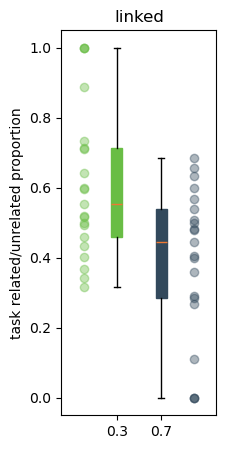

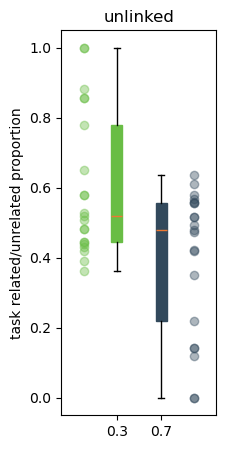

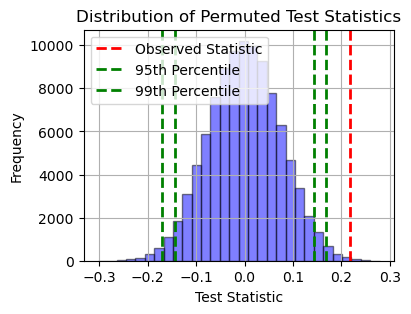

- p-value: 0.00114
- 99th percentile of permuted statistics: 0.1688186085614999
- Observed Test Statistic: 0.21804387437729666
cohens d = 1.0105429108683979
------------------


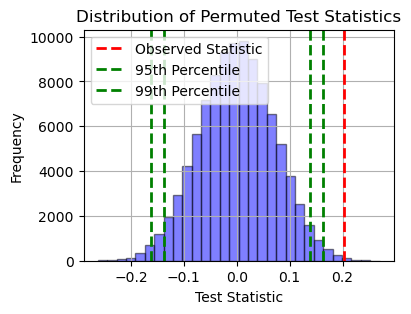

- p-value: 0.00135
- 99th percentile of permuted statistics: 0.1622567822909103
- Observed Test Statistic: 0.2034533193955131
cohens d = 0.9861288042242538
ShapiroResult(statistic=np.float64(0.9126579034299322), pvalue=np.float64(0.06197578614050367))
ShapiroResult(statistic=np.float64(0.9126579034299322), pvalue=np.float64(0.06197578614050367))
ShapiroResult(statistic=np.float64(0.8579719459767392), pvalue=np.float64(0.005845862013744734))
ShapiroResult(statistic=np.float64(0.857971945976739), pvalue=np.float64(0.005845862013744675))
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      42
number of groups                  2
test statistic                 -0.0
p-value                         1.0
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.61931


In [10]:
plot_ordered_misrodered(linked_unlinked_master['linked']['task_nontask'],'linked','task related/unrelated proportion')
plot_ordered_misrodered(linked_unlinked_master['unlinked']['task_nontask'],'unlinked','task related/unrelated proportion')


# STATS
list1 = [float(item[0]) for item in linked_unlinked_master['linked']['task_nontask']] 
list2 = [float(item[1]) for item in linked_unlinked_master['linked']['task_nontask']] 
list1= [x for x in list1 if not np.isnan(x)] 
list2= [x for x in list2 if not np.isnan(x)] 
permutation_test(list1, list2)
print(f'cohens d = {cohens_d(list1, list2)}')

print('------------------')
list3 = [float(item[0]) for item in linked_unlinked_master['unlinked']['task_nontask']] 
list4 = [float(item[1]) for item in linked_unlinked_master['unlinked']['task_nontask']] 
list3= [x for x in list3 if not np.isnan(x)] 
list4= [x for x in list4 if not np.isnan(x)] 
permutation_test(list3, list4)
print(f'cohens d = {cohens_d(list3, list4)}')

# test for normality
print(scipy.stats.shapiro(list1))
print(scipy.stats.shapiro(list2))
print(scipy.stats.shapiro(list3))
print(scipy.stats.shapiro(list4))

#permanova for nrem vs rem
permanova_ordered_misordered(linked_unlinked_master['linked']['task_nontask'], linked_unlinked_master['linked']['task_nontask'])


# figure S

Fitted parameters: a = 0.03367378099734572, b = 3.201351083248676
R-squared: 0.9922724755147638
p-values: [np.float64(2.0593868998775022e-05), np.float64(1.4353792376908814e-08)]
Fitted parameters: a = 0.0328558221580791, b = 3.210093530299527
R-squared: 0.9931276627714299
p-values: [np.float64(1.3138176551796832e-05), np.float64(8.652554006616242e-09)]
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3435 2.0000 17.0000 16.2478 0.0001
         Pillai's trace 0.6565 2.0000 17.0000 16.2478 0.0001
 Hotelling-Lawley trace 1.9115 2.0000 17.0000 16.2478 0.0001
    Roy's greatest root 1.9115 2.0000 17.0000 16.2478 0.0001
------------------------------------------------------------
                                                    

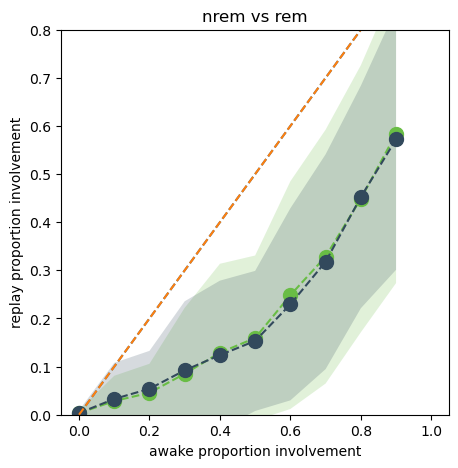

In [11]:
with open(in_path + "awake_seqbyseq_neuron_involvements.pkl", 'rb') as f:
    neuron_involvement_master = pickle.load(f)
    
awake_seqbyseq_neuron_involvements = neuron_involvement_master['awake_seqbyseq_neuron_involvements']

fig, ax = plt.subplots(1, 1,figsize=(5, 5))
nrem_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,linked_unlinked_master['linked']['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(nrem_awake_sleep_relationship,'#69BD45',ax)
rem_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,linked_unlinked_master['unlinked']['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(rem_awake_sleep_relationship,'#32495C',ax)
ax.set_title('nrem vs rem')

## STATS
m =manova_groups_neuron_involvement(nrem_awake_sleep_relationship,rem_awake_sleep_relationship)
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)
